# Learning Flux Through Solving XOR

In [1]:
using Flux
using Plots
using ProgressMeter
using Statistics

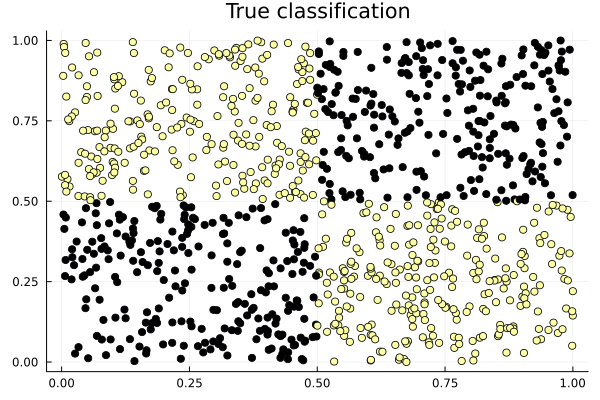

In [2]:
# Generate some noisy XOR Data
noisy = rand(Float32, 2, 1000)
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(noisy)]

# Plot the dataset
p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth, title="True classification", legend=false)
plot(p_true)

In [3]:
# Define our model, a multi-layer perceptron with one hidden layer of size 3:
model = Chain(
    Dense(2 => 3, tanh),   # activation function inside layer
    BatchNorm(3),
    Dense(3 => 2))       # move model to GPU, if available

# The model encapsulates parameters, randomly initialised. Its initial output is:
out1 = model(noisy)                           # 2×1000 Matrix{Float32}
probs1 = softmax(out1)      # normalise to get probabilities

2×1000 Matrix{Float32}:
 0.411045  0.434829  0.450693  0.423472  …  0.464588  0.401838  0.419882
 0.588955  0.565171  0.549307  0.576528     0.535412  0.598162  0.580118

In [4]:
# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target), batchsize=64, shuffle=true);

optim = Flux.setup(Flux.Adam(0.01), model)  # will store optimiser momentum, etc.

(layers = ((weight = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0; 0.0 0.0; 0.0 0.0], Float32[0.0 0.0; 0.0 0.0; 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (λ = (), β = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0], (0.9, 0.999))), γ = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0], (0.9, 0.999))), μ = (), σ² = (), ϵ = (), momentum = (), affine = (), track_stats = (), active = (), chs = ()), (weight = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 0.0; 0.0 0.0 0.0], Float32[0.0 0.0 0.0; 0.0 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0], Float32[0.0, 0.0], (0.9, 0.999))), σ = ())),)

In [5]:
# Training loop, using the whole data set 1000 times:
losses = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        los, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.logitcrossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, los)  # logging, outside gradient context
    end
end

optim # parameters, momenta and output have all changed
out2 = model(noisy) # first row is prob. of true, second row p(false)
probs2 = softmax(out2)      # normalise to get probabilities
mean((probs2[1,:] .> 0.5) .== truth)  # accuracy 94% so far!

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
┌ Info: The CUDA functionality is being called but
│ `CUDA.jl` must be loaded to access it.
│ Add `using CUDA` or `import CUDA` to your code.  Alternatively, configure a different GPU backend by calling `Flux.gpu_backend!`.
└ @ Flux C:\Users\zachl\.julia\packages\Flux\htpCe\src\functor.jl:338


0.948

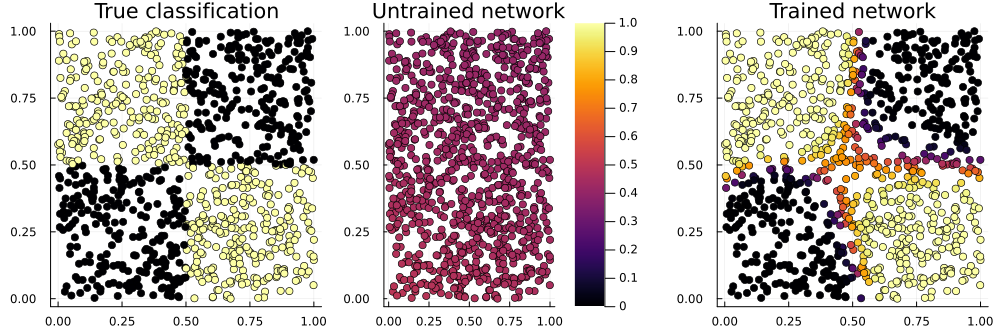

In [6]:
p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth, title="True classification", legend=false)
p_raw =  scatter(noisy[1,:], noisy[2,:], zcolor=probs1[1,:], title="Untrained network", label="", clims=(0,1))
p_done = scatter(noisy[1,:], noisy[2,:], zcolor=probs2[1,:], title="Trained network", legend=false)

plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,330))

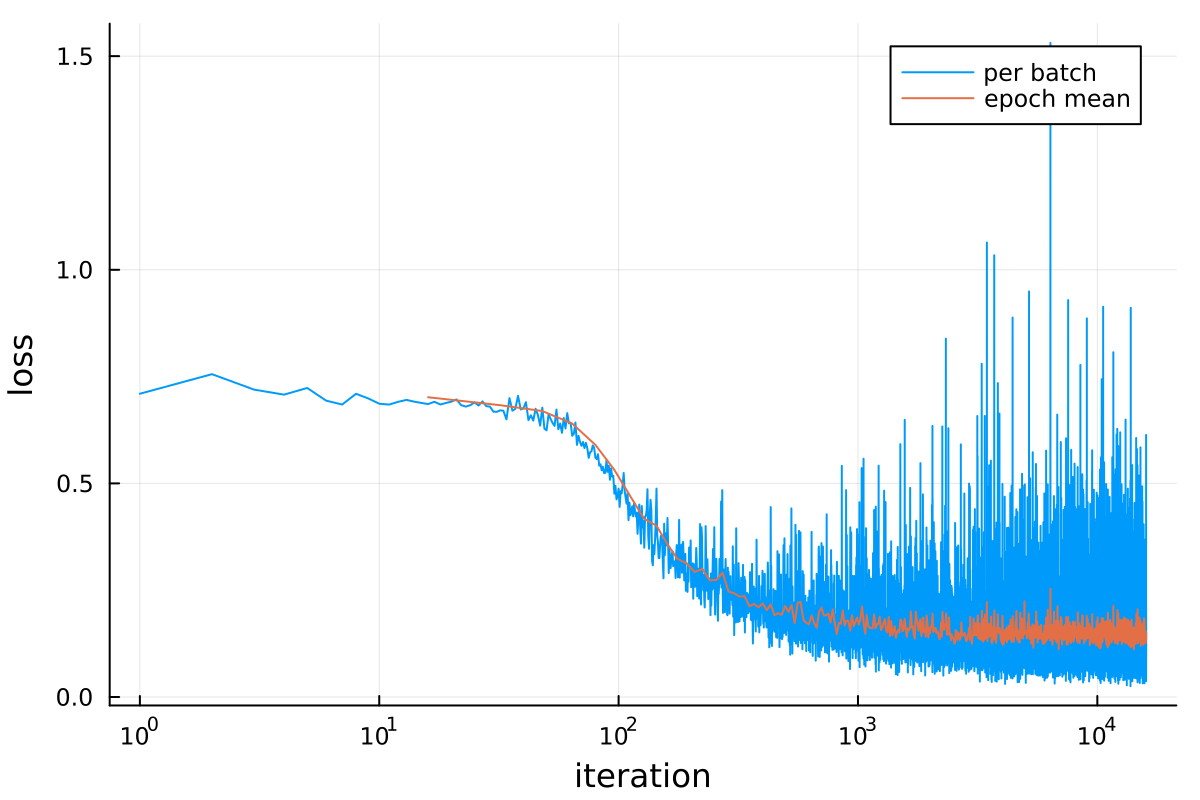

In [7]:
plot(losses; xaxis=(:log10, "iteration"),
    yaxis="loss", label="per batch")
n = length(loader)
plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)),
    label="epoch mean", dpi=200)